In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn.decomposition import NMF
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.metrics.cluster import adjusted_rand_score as ARI
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI
from sklearn.metrics import roc_curve, auc, mean_squared_error, mean_absolute_error, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd, squared_norm
import umap
from scipy.sparse.csgraph import connected_components
import networkx as nx
import community
import cvxpy as cp
import cvxopt
import pickle
import math
from math import sqrt
import random
import scipy as sp
from scipy.cluster.hierarchy import linkage,dendrogram
from scipy.special import comb
from scipy.stats import poisson
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix

In [299]:
results = pd.DataFrame(index=[], 
                       columns=["version", "m", "n_cl", "n_incl", "sparse_rate", "hetero_rate", "drop_rate", "sim_matrix", "r", "lambdaW", "lambdaH", "lambdaC", "RMSE", "MAE", "AUROC", "AUPRC"])#, "kARI", "kNMI", "lARI", "lNMI"])

In [220]:
version = "v1"

In [67]:
! mkdir /home/naoto/scOpen/simulation1/{version}

In [176]:
def create_sparse_mtx(M, rate):
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if M[i][j] == 1:
                rand = np.random.rand(1)
                if rand < rate:
                    M[i][j] = 0
    return M


In [671]:
m = 100
n_cl = 8
n_incl = 10
sparse_rates = [0.3]
hetero_rates = [0.2]
for sparse_rate in sparse_rates:
    for hetero_rate in hetero_rates:
        for version in range(1,2):
            version = "v{}".format(version)
            M = np.random.randint(0,2,(m,n_cl))
            M = create_sparse_mtx(M, sparse_rate)

            M_hetero = np.empty((m, n_incl))
            for j in range(n_cl):
                M_cl = M[:,j].repeat(n_incl, axis=0).reshape(m,n_incl)
                for i in np.where(M[:,j]==1)[0]:
                    for jj in range(n_cl):
                        rand = np.random.rand(1)
                        if rand < hetero_rate:
                            M_cl[i,jj] = 0
                M_hetero = np.hstack([M_hetero, M_cl])
            M_hetero = M_hetero[:,n_incl:]
            print(M_hetero.shape)
            M = M_hetero.copy()
            ! mkdir /home/naoto/scOpen/simulation1/{version}
            pd.DataFrame(M).to_csv("/home/naoto/scOpen/simulation1/{}/easiestM.tsv".format(version), sep="\t", index=False,header=None)
            
#             M = pd.read_csv("/home/naoto/scOpen/simulation1/{}/easiestM.tsv".format(version), sep="\t", header=None).to_numpy()


(100, 80)
mkdir: cannot create directory ‘/home/naoto/scOpen/simulation1/v1’: File exists


In [672]:
# LSI.ipynbでLSIを実行し、M_lsiファイルを生成
M_lsi = pd.read_csv("/home/naoto/scOpen/simulation1/{}/easiestM_lsi.tsv".format(version), sep="\t")
S_lsi_M = sklearn.metrics.pairwise.cosine_similarity(M_lsi.iloc[:, 1:10]) 

In [316]:
for div in [2,3]:
    for add in [0, 3]:
        for _i in range(3):
            print(_i)
            X = M.copy()
            drop_rates = []
            for j in range(M.shape[1]):
                n_drop = np.random.poisson(math.floor(M[:,j].sum() / div), 1) + add
                print(n_drop)
                n_drop = n_drop[0]
                if n_drop >= M[:,j].sum():
                    n_drop = int(M[:,j].sum() - 1)
                print(n_drop,  M[:,j].sum(), n_drop / M[:,j].sum())
                drop_rates.append(n_drop / M[:,j].sum())
                drop_idxs = np.random.choice(np.where(M[:,j] == 1)[0], n_drop, replace=False)
                for drop_idx in drop_idxs:
                    X[drop_idx,j] = 0

            drop_rate = np.array(drop_rates).mean()

            ##
            M_bin = M.copy()

            rmse_x = mean_squared_error(M_bin, X, squared=False)
            mae_x = mean_absolute_error(M_bin, X)
            # print(rmse_x, mae_x)

            fpr_x, tpr_x, thresholds_x = roc_curve(M_bin.flatten(), X.flatten())
            roc_auc_x = auc(fpr_x, tpr_x)
            # print(roc_auc_x)

            precision_x, recall_x, thresholds_pr_x = precision_recall_curve(M_bin.flatten(), X.flatten())
            auprc_x= auc(recall_x, precision_x)
            # print(auprc_x)

            ##
            record =  pd.Series([version, m, n_cl, n_incl, sparse_rate, hetero_rate, drop_rate, "X", 0, 1, 1, 0, rmse_x, mae_x, roc_auc_x, auprc_x], index=results.columns)
            results = results.append(record, ignore_index=True)
            ##

            rs = [5,8,10,20,30,40,50]
            lambdaCs = [0, 0.1, 1]

            for r in rs:
                for lambdaC in lambdaCs:
                    for sim in ["S_lsi_M", "S_lsi_X"]:
                        if sim == "S_lsi_M":
                            WH, W, H, errors = CMF_Impute(X, S_lsi_M, r, 1,1,lambdaC, False)
                        elif sim == "S_lsi_X":
                            WH, W, H, errors = CMF_Impute(X, S_lsi_X, r, 1,1,lambdaC, False)
                        WH[WH < 0] = 0

                        AA = X.astype(float)
                        for i in range(X.shape[0]):
            #                 if i % 100 == 0:
            #                     print(i)
                            for j in range(X.shape[1]):
                                if X[i,j] == 0:
                                    AA[i,j] = WH[i,j]

                        rmse_aa = mean_squared_error(M_bin, AA, squared=False)
                        mae_aa = mean_absolute_error(M_bin, AA)
            #             print(rmse_aa, mae_aa)

                        fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
                        roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
            #             print(roc_auc_nhmf_aa)


                        precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
                        auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
            #             print(auprc_nhmf_aa)

                        record =  pd.Series([version, m, n_cl, n_incl, sparse_rate, hetero_rate, drop_rate, sim, r, 1, 1, lambdaC, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
                        results = results.append(record, ignore_index=True)

            pd.DataFrame(X).to_csv("hoge.tsv", sep="\t")
            for r in rs:

                !scopen --input hoge.tsv --input-format dense --output-dir ./ --output-prefix hoge_scOpen --output-format dense --n-components {r}          
                WH = pd.read_csv("hoge_scOpen.txt", sep="\t", index_col=0).to_numpy()
            #     print(WH.shape)

                WH[WH < 0] = 0

                AA = X.astype(float)
                for i in range(X.shape[0]):
            #         if i % 100 == 0:
            #             print(i)
                    for j in range(X.shape[1]):
                        if X[i,j] == 0:
                            AA[i,j] = WH[i,j]

                rmse_aa = mean_squared_error(M_bin, AA, squared=False)
                mae_aa = mean_absolute_error(M_bin, AA)
            #     print(rmse_aa, mae_aa)

                fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
                roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
            #     print(roc_auc_nhmf_aa)


                precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
                auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
            #     print(auprc_nhmf_aa)

                record =  pd.Series([version, m, n_cl, n_incl, sparse_rate, hetero_rate, drop_rate, "scOpen", r, 1, 1, 0, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
                results = results.append(record, ignore_index=True)
            print(results.shape)

0
[9]
9 23.0 0.391304347826087
[8]
8 23.0 0.34782608695652173
[15]
15 28.0 0.5357142857142857
[24]
24 26.0 0.9230769230769231
[11]
11 24.0 0.4583333333333333
[15]
15 25.0 0.6
[9]
9 23.0 0.391304347826087
[15]
15 24.0 0.625
[14]
14 31.0 0.45161290322580644
[15]
15 31.0 0.4838709677419355
[19]
19 39.0 0.48717948717948717
[16]
16 37.0 0.43243243243243246
[20]
20 37.0 0.5405405405405406
[16]
16 38.0 0.42105263157894735
[13]
13 34.0 0.38235294117647056
[14]
14 38.0 0.3684210526315789
[23]
23 35.0 0.6571428571428571
[19]
19 33.0 0.5757575757575758
[27]
27 46.0 0.5869565217391305
[24]
24 46.0 0.5217391304347826
[12]
12 24.0 0.5
[5]
5 18.0 0.2777777777777778
[9]
9 25.0 0.36
[6]
6 21.0 0.2857142857142857
[11]
11 25.0 0.44
[14]
14 22.0 0.6363636363636364
[8]
8 23.0 0.34782608695652173
[4]
4 18.0 0.2222222222222222
[11]
11 28.0 0.39285714285714285
[9]
9 28.0 0.32142857142857145
[14]
14 27.0 0.5185185185185185
[11]
11 27.0 0.4074074074074074
[11]
11 27.0 0.4074074074074074
[14]
14 30.0 0.466666666

In [317]:
results

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,v1,100,8,10,0.3,0.2,0.472693,X,0,1,1,0,0.371520,0.142625,0.763376,0.834689
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0,0.297086,0.159271,0.934994,0.897490
2,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0,0.297086,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.295762,0.156675,0.939060,0.902168
4,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.1,0.296071,0.156706,0.938201,0.901501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,v5,100,8,10,0.3,0.2,0.416030,scOpen,10,1,1,0,0.240931,0.127599,0.975590,0.950150
2996,v5,100,8,10,0.3,0.2,0.416030,scOpen,20,1,1,0,0.261765,0.137600,0.957531,0.930582
2997,v5,100,8,10,0.3,0.2,0.416030,scOpen,30,1,1,0,0.271232,0.141174,0.948000,0.920324
2998,v5,100,8,10,0.3,0.2,0.416030,scOpen,40,1,1,0,0.279357,0.143754,0.942836,0.912083


<AxesSubplot:>

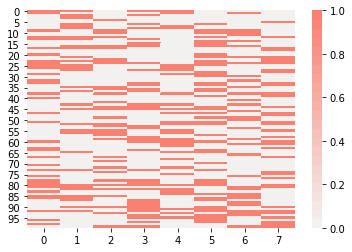

In [165]:
sns.heatmap(M, cmap=sns.light_palette("salmon", 24))

<AxesSubplot:>

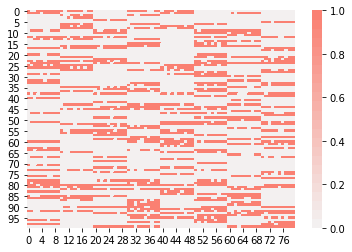

In [168]:
sns.heatmap(M_hetero, cmap=sns.light_palette("salmon", 24))

<AxesSubplot:>

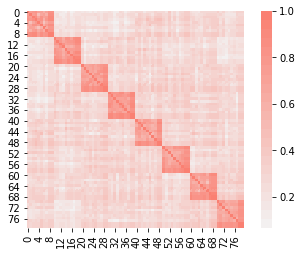

In [13]:
S_M = sklearn.metrics.pairwise.cosine_similarity(M.T)
sns.heatmap(S_M, cmap=sns.light_palette("salmon", 24), square=True)

In [82]:
M = pd.read_csv("/home/naoto/scOpen/simulation1/{}/easiestM.tsv".format(version), sep="\t", header=None).to_numpy()

In [22]:
pd.DataFrame(M).to_csv("/home/naoto/scOpen/simulation1/{}/easiestM.tsv".format(version), sep="\t", index=False,header=None)

### Dropout (generate M)

In [199]:
for _i in range(3):
    print(_i)
    X = M.copy()
    div = 2
    drop_rates = []
    for j in range(M.shape[1]):
        n_drop = np.random.poisson(math.floor(M[:,j].sum() / div), 1) + 3
        if n_drop >= M[:,j].sum():
            n_drop = n_drop - 1
        drop_rates.append((n_drop / M[:,j].sum())[0])
        drop_idxs = np.random.choice(np.where(M[:,j] == 1)[0], n_drop, replace=False)
        for drop_idx in drop_idxs:
            X[drop_idx,j] = 0

    drop_rate = np.array(drop_rates).mean()

    ##
    M_bin = M.copy()

    rmse_x = mean_squared_error(M_bin, X, squared=False)
    mae_x = mean_absolute_error(M_bin, X)
    # print(rmse_x, mae_x)

    fpr_x, tpr_x, thresholds_x = roc_curve(M_bin.flatten(), X.flatten())
    roc_auc_x = auc(fpr_x, tpr_x)
    # print(roc_auc_x)

    precision_x, recall_x, thresholds_pr_x = precision_recall_curve(M_bin.flatten(), X.flatten())
    auprc_x= auc(recall_x, precision_x)
    # print(auprc_x)

    ##
    record =  pd.Series([version, m, n_cl, n_incl, drop_rate, "X", 0, 1, 1, 0, rmse_x, mae_x, roc_auc_x, auprc_x], index=results.columns)
    results = results.append(record, ignore_index=True)
    ##

    rs = [5,8,10,20,30,40,50]
    lambdaCs = [0, 0.1, 1]

    for r in rs:
        for lambdaC in lambdaCs:
            for sim in ["S_lsi_M", "S_lsi_X"]:
                if sim == "S_lsi_M":
                    WH, W, H, errors = CMF_Impute(X, S_lsi_M, r, 1,1,lambdaC, False)
                elif sim == "S_lsi_X":
                    WH, W, H, errors = CMF_Impute(X, S_lsi_X, r, 1,1,lambdaC, False)
                WH[WH < 0] = 0

                AA = X.astype(float)
                for i in range(X.shape[0]):
    #                 if i % 100 == 0:
    #                     print(i)
                    for j in range(X.shape[1]):
                        if X[i,j] == 0:
                            AA[i,j] = WH[i,j]

                rmse_aa = mean_squared_error(M_bin, AA, squared=False)
                mae_aa = mean_absolute_error(M_bin, AA)
    #             print(rmse_aa, mae_aa)

                fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
                roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
    #             print(roc_auc_nhmf_aa)


                precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
                auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
    #             print(auprc_nhmf_aa)

                record =  pd.Series([version, m, n_cl, n_incl, drop_rate, sim, r, 1, 1, lambdaC, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
                results = results.append(record, ignore_index=True)

    pd.DataFrame(X).to_csv("hoge.tsv", sep="\t")
    for r in rs:

        !scopen --input hoge.tsv --input-format dense --output-dir ./ --output-prefix hoge_scOpen --output-format dense --n-components {r}          
        WH = pd.read_csv("hoge_scOpen.txt", sep="\t", index_col=0).to_numpy()
    #     print(WH.shape)

        WH[WH < 0] = 0

        AA = X.astype(float)
        for i in range(X.shape[0]):
    #         if i % 100 == 0:
    #             print(i)
            for j in range(X.shape[1]):
                if X[i,j] == 0:
                    AA[i,j] = WH[i,j]

        rmse_aa = mean_squared_error(M_bin, AA, squared=False)
        mae_aa = mean_absolute_error(M_bin, AA)
    #     print(rmse_aa, mae_aa)

        fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
        roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
    #     print(roc_auc_nhmf_aa)


        precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
        auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
    #     print(auprc_nhmf_aa)

        record =  pd.Series([version, m, n_cl, n_incl, drop_rate, "scOpen", r, 1, 1, 0, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
        results = results.append(record, ignore_index=True)
        print(results.shape)

0
Number of peaks: 100; number of cells 80
Sparsity before imputation: 0.8825000000000001
Sparsity after imputation: 0.12537500000000001
[total time:  0h 0m 0s ]
(144, 14)
Number of peaks: 100; number of cells 80
Sparsity before imputation: 0.8825000000000001
Sparsity after imputation: 0.138625
[total time:  0h 0m 0s ]
(145, 14)
Number of peaks: 100; number of cells 80
Sparsity before imputation: 0.8825000000000001
Sparsity after imputation: 0.11499999999999999
[total time:  0h 0m 0s ]
(146, 14)
Number of peaks: 100; number of cells 80
Sparsity before imputation: 0.8825000000000001
Sparsity after imputation: 0.111375
[total time:  0h 0m 0s ]
(147, 14)
Number of peaks: 100; number of cells 80
Sparsity before imputation: 0.8825000000000001
Sparsity after imputation: 0.09387500000000004
[total time:  0h 0m 0s ]
(148, 14)
Number of peaks: 100; number of cells 80
Sparsity before imputation: 0.8825000000000001
Sparsity after imputation: 0.08825000000000005
[total time:  0h 0m 0s ]
(149, 14)


0.5801119298967438


(array([ 5.,  6., 11., 20.,  8.,  9., 12.,  5.,  3.,  1.]),
 array([0.29166667, 0.35795455, 0.42424242, 0.4905303 , 0.55681818,
        0.62310606, 0.68939394, 0.75568182, 0.8219697 , 0.88825758,
        0.95454545]),
 <BarContainer object of 10 artists>)

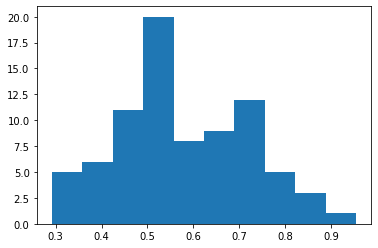

In [191]:

print(drop_rate)
plt.hist(drop_rates)

(array([ 6., 11., 21., 19., 17.,  7., 14.,  3.,  1.,  1.]),
 array([ 0. ,  3.1,  6.2,  9.3, 12.4, 15.5, 18.6, 21.7, 24.8, 27.9, 31. ]),
 <BarContainer object of 10 artists>)

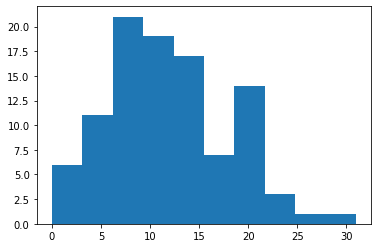

In [36]:
plt.hist(X.sum(axis=1))

<AxesSubplot:>

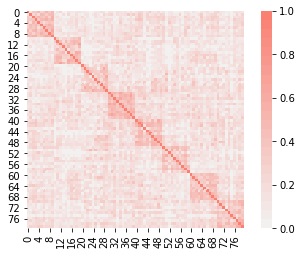

In [37]:
S_X = sklearn.metrics.pairwise.cosine_similarity(X.T)
sns.heatmap(S_X, cmap=sns.light_palette("salmon", 24), square=True)

<AxesSubplot:>

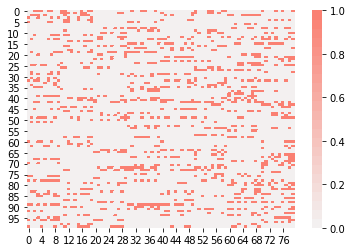

In [38]:
sns.heatmap(X, cmap=sns.light_palette("salmon", 24))

In [180]:
pd.DataFrame(X).to_csv("/home/naoto/scOpen/simulation1/{}/easiestX.tsv".format(version), sep="\t", index=False,header=None)

In [20]:
label = np.arange(n_cl).repeat(n_incl, axis=0)
label_cat = np.arange(n_cl).repeat(n_incl, axis=0)
# pd.DataFrame(label).to_csv("/home/naoto/scOpen/basic_sim/{}/easiestM_label.tsv".format(version), sep="\t", index=False,header=None)
label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [23]:
M_lsi = pd.read_csv("/home/naoto/scOpen/simulation1/{}/easiestM_lsi.tsv".format(version), sep="\t")
M_lsi.iloc[:,0:10]

,LSI_1,LSI_2,LSI_3,LSI_4,LSI_5,LSI_6,LSI_7,LSI_8,LSI_9,LSI_10
cell1,1.087139,0.820805,0.937051,-1.645894,-0.793961,-0.140025,0.195721,1.511402,0.505075,-0.675157
cell2,0.804369,0.634721,0.915539,-1.527393,-0.536065,-0.079802,0.503441,1.471708,1.606399,2.803463
cell3,0.133953,0.590881,1.024726,-1.933475,-0.623554,-0.013616,0.370178,1.384088,0.938133,0.521639
cell4,0.060413,0.781837,1.088269,-2.108000,-0.684310,-0.272560,0.461095,1.066326,-0.249298,-0.295285
cell5,1.554540,0.629409,0.561675,-1.507578,-0.492894,-0.104056,0.196189,0.406240,-1.569332,-2.494093
...,...,...,...,...,...,...,...,...,...,...
cell76,-0.175231,1.324301,-0.562427,0.915171,-1.120354,-0.902014,-1.049301,-0.621649,1.072442,-1.253728
cell77,-0.111278,1.180577,-0.693762,0.861446,-1.089488,-0.977369,-0.979345,-0.506623,0.281534,-1.781134
cell78,-0.310816,1.779954,-0.930467,0.419637,-0.608050,-1.369437,-1.008514,0.016977,1.088842,2.021949
cell79,-2.687181,1.950296,-0.916947,1.157981,-1.442543,-1.202764,-0.831331,-0.311982,0.125572,0.144259


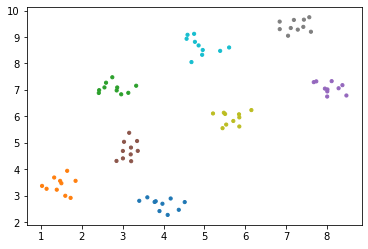

In [24]:
embedding_M = umap.UMAP().fit_transform(M_lsi.iloc[:,1:15])
plt.scatter(embedding_M[:,0],embedding_M[:,1],c=label,cmap=cm.tab10, s=10)

<AxesSubplot:>

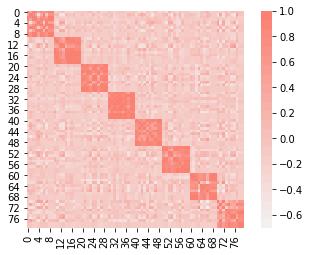

In [25]:
S_lsi_M = sklearn.metrics.pairwise.cosine_similarity(M_lsi.iloc[:, 1:10])
sns.heatmap(S_lsi_M, cmap=sns.light_palette("salmon", 24), square=True)

In [40]:
X_lsi = pd.read_csv("/home/naoto/scOpen/simulation1/{}/easiestX_lsi.tsv".format(version), sep="\t")
# X_lsi.iloc[:,0:10]

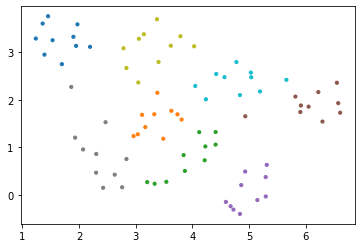

In [41]:
embedding_X = umap.UMAP().fit_transform(X_lsi.iloc[:,1:15])
plt.scatter(embedding_X[:,0],embedding_X[:,1],c=label,cmap=cm.tab10, s=10)

<AxesSubplot:>

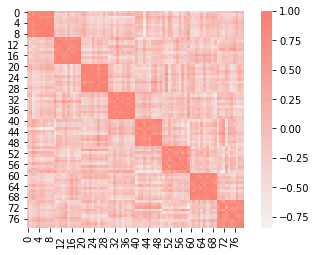

In [42]:
S_lsi_X = sklearn.metrics.pairwise.cosine_similarity(X_lsi.iloc[:, 1:8])
sns.heatmap(S_lsi_X, cmap=sns.light_palette("salmon", 24), square=True)

0.4152438380102172 0.176375
0.7122756933115824
0.8004631933115824


In [195]:
results.shape

(51, 14)

## NHMF

In [188]:
def CMF_Impute(X, S_c, r, lambda1, lambda2, lambdaC, positive=False):
    # input
    # X: peak-by-cell raw matrix (m, n)
    # S_c: cell-cell similarity matirx (n,n)
    
    # variable
    # W: (m,r)
    # H: (n,r)
    # I: eye(r)
    #r = int(n / _n)
    #X = X[:,:] * (1 / (1 - 0.9))
    #X = X * (1 / (1 - drop_rates_real))
#     X = scaling(X)

#     W, H = nndsvd_init(X,r)
    m = X.shape[0]
    n = X.shape[1]
    W = np.random.rand(m,r)
    H = np.random.rand(n,r)
    I = np.eye(r)
    
    # paremeters
    err = 1e-5
    max_iter = 300
    errors = []
    
    for _i in range(max_iter):
#         if _i % 100 == 0:
#             print(_i)

        W = (X @ H) @ np.linalg.inv(H.T @ H + lambda1 * I)
        if positive:
            W[W < 0] = 0
        H = (X.T @ W + lambdaC * S_c @ H) @ np.linalg.inv(W.T @ W + lambda2 * I + lambdaC * H.T @ H)
        if positive:
            H[H < 0] = 0

#         error = np.mean(np.mean(np.abs(A - H @ W.T))) / np.mean(np.mean(A))
        error = np.linalg.norm(X - W @ H.T, "fro")
        # + lambda1 * np.linalg.norm(W, "fro") + lambda2 * np.linalg.norm(H, "fro") + lambdaC * np.linalg.norm(S_c - H.T @ H, "fro")
        errors.append(error)
        
        if error < err:
            break
    return W @ H.T, W, H, errors
#     WH =  W @ H.T
#     WH_pos = np.where(WH < 0, 0, WH)
#     print("Imputing...")
#     AA = X.astype(float)
#     for i in range(m):
#         if i % 100 == 0:
#             print(i)
#         for j in range(n):
#             if X[i,j] == 0:
#                 AA[i,j] = WH_pos[i,j]
#     return AA, W, H, errors

In [184]:
# def calc_drop_rate_real(s_j):
#     return max_rate * (math.log(s_max_real) - math.log(s_j)) / (math.log(s_max_real) - math.log(s_min_real))

# def scaling(X, max_rate=0.5, min_rate=0.0):
#     s_sum_real = X.sum(axis=0)
#     s_max_real = max(s_sum_real)
#     s_min_real = min(s_sum_real)
#     drop_rates_real = np.array(list(map(lambda x: max_rate * (math.log(s_max_real) - math.log(x)) / (math.log(s_max_real) - math.log(s_min_real)), s_sum_real)))

#     return X * (1 / (1 - drop_rates_real))
    
# #     n_open_cells = np.log10(X.sum(axis=1))
# #     n_open_regions = np.log10(X.sum(axis=0))
    
# #     hoge = n_open_cells.reshape(-1,1) * n_open_regions.reshape(1,-1)
# #     mx = np.max(hoge)
# #     mn = np.min(hoge)
# #     print(mx, mn)

# #     rho = min_rho + (max_rho - min_rho) * \
# #           (mx - hoge) / (mx - mn)
# #     XX = X[:, :] * (1 / (1 - rho))
#     return XX

In [196]:
rs = [5,8,10,20,30,40,50]
lambdaCs = [0, 0.1, 1]

for r in rs:
    for lambdaC in lambdaCs:
        for sim in ["S_lsi_M", "S_lsi_X"]:
            if sim == "S_lsi_M":
                WH, W, H, errors = CMF_Impute(X, S_lsi_M, r, 1,1,lambdaC, False)
            elif sim == "S_lsi_X":
                WH, W, H, errors = CMF_Impute(X, S_lsi_X, r, 1,1,lambdaC, False)
            WH[WH < 0] = 0

            AA = X.astype(float)
            for i in range(X.shape[0]):
#                 if i % 100 == 0:
#                     print(i)
                for j in range(X.shape[1]):
                    if X[i,j] == 0:
                        AA[i,j] = WH[i,j]

            rmse_aa = mean_squared_error(M_bin, AA, squared=False)
            mae_aa = mean_absolute_error(M_bin, AA)
            print(rmse_aa, mae_aa)

            fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
            roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
            print(roc_auc_nhmf_aa)


            precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
            auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
            print(auprc_nhmf_aa)

            record =  pd.Series([version, m, n_cl, n_incl, drop_rate, sim, r, 1, 1, lambdaC, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
            results = results.append(record, ignore_index=True)
        
pd.DataFrame(X).to_csv("hoge.tsv", sep="\t")
for r in rs:

    !scopen --input hoge.tsv --input-format dense --output-dir ./ --output-prefix hoge_scOpen --output-format dense --n-components {r}          
    WH = pd.read_csv("hoge_scOpen.txt", sep="\t", index_col=0).to_numpy()
    print(WH.shape)

    WH[WH < 0] = 0

    AA = X.astype(float)
    for i in range(X.shape[0]):
#         if i % 100 == 0:
#             print(i)
        for j in range(X.shape[1]):
            if X[i,j] == 0:
                AA[i,j] = WH[i,j]

    rmse_aa = mean_squared_error(M_bin, AA, squared=False)
    mae_aa = mean_absolute_error(M_bin, AA)
    print(rmse_aa, mae_aa)

    fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
    roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
    print(roc_auc_nhmf_aa)


    precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
    auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
    print(auprc_nhmf_aa)

    record =  pd.Series([version, m, n_cl, n_incl, drop_rate, "scOpen", r, 1, 1, 0, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa], index=results.columns)
    results = results.append(record, ignore_index=True)

0.34866325207131893 0.1875350303676094
0.8927760514495472
0.8394578679771395
0.3479960493592407 0.1862315167419621
0.8969134564606559
0.841958094042695
0.3428336640331591 0.18165560216288384
0.9107520485609204
0.8593002308014512
0.3423217788473519 0.1813977246600411
0.9122950115909676
0.8606910278526254
0.3370669641329823 0.17534061171800547
0.9288181682389846
0.8847855234374611
0.3429102121277591 0.17953034680506524
0.909102239567835
0.864706871078932
0.33664913181936734 0.17279045048454128
0.9242294888095118
0.8819245210511231
0.33664913181936734 0.17279045048454128
0.9242294888095118
0.8819245210511231
0.33139357122715174 0.16641986062187536
0.9407925610804593
0.901272254334965
0.33064051599020844 0.1658650339039974
0.9425393657723606
0.902860233857853
0.31788909250694414 0.15126943688750225
0.970371103558915
0.9350732316699769
0.3231376320711906 0.16051632069349875
0.9547567808042757
0.9175210604910014
0.3428114170690415 0.17566484181810704
0.9071101338930243
0.8669856186958597
0.3

In [198]:
results.shape

(100, 14)

In [357]:
results

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0,0.297086,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.295762,0.156675,0.939060,0.902168
5,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,1,0.288747,0.148323,0.954636,0.919801
7,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,8,1,1,0,0.279463,0.139184,0.964675,0.934240
9,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,8,1,1,0.1,0.275768,0.134341,0.970315,0.941083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,40,1,1,0.1,0.309460,0.132933,0.925558,0.898675
2985,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,40,1,1,1,0.295887,0.124092,0.959861,0.937131
2987,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,50,1,1,0,0.317495,0.133723,0.919577,0.889785
2989,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,50,1,1,0.1,0.313525,0.130114,0.938287,0.910457


In [318]:
results.to_csv("simulation1_20210131_results_m{}_ncl{}_nincl{}_sparse{}_hetero{}.tsv".format(m, n_cl, n_incl, sparse_rate, hetero_rate), sep="\t")

In [5]:
m = 100
n_cl = 8
n_incl = 10
sparse_rate = 0.3
hetero_rate = 0.2

In [6]:
results = pd.read_csv("simulation1_20210131_results_m{}_ncl{}_nincl{}_sparse{}_hetero{}.tsv".format(m, n_cl, n_incl, sparse_rate, hetero_rate), sep="\t", index_col=0)
results

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,v1,100,8,10,0.3,0.2,0.472693,X,0,1,1,0.0,0.371520,0.142625,0.763376,0.834689
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.0,0.297086,0.159271,0.934994,0.897490
2,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.0,0.297086,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.295762,0.156675,0.939060,0.902168
4,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.1,0.296071,0.156706,0.938201,0.901501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,v5,100,8,10,0.3,0.2,0.416030,scOpen,10,1,1,0.0,0.240931,0.127599,0.975590,0.950150
2996,v5,100,8,10,0.3,0.2,0.416030,scOpen,20,1,1,0.0,0.261765,0.137600,0.957531,0.930582
2997,v5,100,8,10,0.3,0.2,0.416030,scOpen,30,1,1,0.0,0.271232,0.141174,0.948000,0.920324
2998,v5,100,8,10,0.3,0.2,0.416030,scOpen,40,1,1,0.0,0.279357,0.143754,0.942836,0.912083


In [21]:
results["RMSE"] = np.sqrt(results["RMSE"])
results

/usr/local/package/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.0,0.545056,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.543840,0.156675,0.939060,0.902168
5,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,1.0,0.537352,0.148323,0.954636,0.919801
7,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,8,1,1,0.0,0.528643,0.139184,0.964675,0.934240
9,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,8,1,1,0.1,0.525136,0.134341,0.970315,0.941083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,40,1,1,0.1,0.556291,0.132933,0.925558,0.898675
2985,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,40,1,1,1.0,0.543955,0.124092,0.959861,0.937131
2987,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,50,1,1,0.0,0.563467,0.133723,0.919577,0.889785
2989,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,50,1,1,0.1,0.559933,0.130114,0.938287,0.910457


## Dropoutの違いによる改善度合い
0 vs 1

scOpen vs 1

In [34]:
results = results[results["sim_matrix"] == "S_lsi_M"]
results

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.0,0.545056,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.543840,0.156675,0.939060,0.902168
5,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,1.0,0.537352,0.148323,0.954636,0.919801
7,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,8,1,1,0.0,0.528643,0.139184,0.964675,0.934240
9,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,8,1,1,0.1,0.525136,0.134341,0.970315,0.941083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,40,1,1,0.1,0.556291,0.132933,0.925558,0.898675
2985,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,40,1,1,1.0,0.543955,0.124092,0.959861,0.937131
2987,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,50,1,1,0.0,0.563467,0.133723,0.919577,0.889785
2989,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,50,1,1,0.1,0.559933,0.130114,0.938287,0.910457


In [23]:
rs = [5,8,10,20,30,40,50]

In [24]:
# lb = 0.55
# ub = 0.65

rocs_all = []
prs_all = []
rmses_all = []
maes_all = []

for lb,ub in [[0.25, 0.35],[0.35, 0.45],[0.45, 0.55],[0.55, 0.65]]:
    rocs = np.array([])
    prs = np.array([])
    rmses = np.array([])
    maes = np.array([])

    df_sub = results[(results["drop_rate"] > lb) & (results["drop_rate"] < ub)]
    for r in rs:
        df_hoge = df_sub[df_sub["r"]== r]
        df_diff = df_hoge[df_hoge["lambdaC"] == 1][["RMSE", "MAE", "AUROC", "AUPRC"]].to_numpy() - df_hoge[df_hoge["lambdaC"] == 0][["RMSE", "MAE", "AUROC", "AUPRC"]].to_numpy()
    #     print(df_diff)
        rmses = np.append(rmses, np.array(df_diff[:,0]).flatten() * -1)
        maes = np.append(maes, np.array(df_diff[:,1]).flatten() * -1)
        rocs = np.append(rocs, np.array(df_diff[:,2]).flatten())
        prs = np.append(prs, np.array(df_diff[:,3]).flatten())
    #     rmses.append(df_diff["RMSE"])
    #     maes.append(df_diff["MAE"])
    #     rocs.append(df_diff["AUROC"])
    #     prs.append(df_diff["AUPRC"])
    rmses_all.append(rmses)
    maes_all.append(maes)
    rocs_all.append(rocs)
    prs_all.append(prs)

In [25]:
rmses_all

[array([ 0.00642034,  0.0081133 ,  0.00698303,  0.00735712,  0.00567638,
         0.00451358,  0.00745478,  0.00680624,  0.00707739,  0.00637656,
         0.00748825,  0.00610233,  0.00897085,  0.00762736,  0.00652484,
         0.00966348,  0.01311512,  0.01154401,  0.01054135,  0.00976905,
         0.00869357,  0.01014795,  0.01050593,  0.01177813,  0.00971142,
         0.00958925,  0.01073355,  0.0109918 ,  0.00979008,  0.00978477,
         0.01896727,  0.02148202,  0.01835073,  0.01952513,  0.01670616,
         0.01553365,  0.02055757,  0.01989462,  0.01938512,  0.02181181,
         0.0185209 ,  0.01970937,  0.01899965,  0.01831496,  0.01938719,
         0.0180204 ,  0.01794453,  0.01809031,  0.01761485,  0.0165438 ,
         0.01403011,  0.01911068,  0.01620382,  0.01781543,  0.0172159 ,
         0.0172309 ,  0.01728309,  0.01792528,  0.0181119 ,  0.01659673,
         0.01709242,  0.01730952,  0.01683017,  0.01730422,  0.01721272,
         0.01454319,  0.01803561,  0.01692022,  0.0

/usr/local/package/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


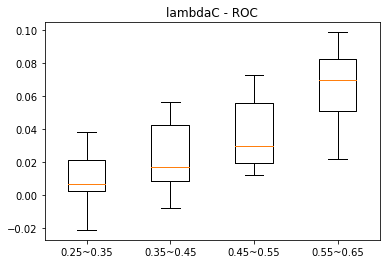

In [26]:
# dropout rate vs ROC
data = (rocs_all[0], rocs_all[1], rocs_all[2], rocs_all[3])
fig1, ax1 = plt.subplots()
ax1.set_title('lambdaC - ROC')
ax1.set_xticklabels(['0.25~0.35', '0.35~0.45', '0.45~0.55', '0.55~0.65'])
ax1.boxplot(data)
# plt.axhline([0,10,20], c='r')
plt.show()

/usr/local/package/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


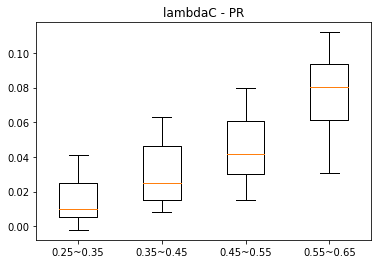

In [27]:
# dropout rate vs PR
data = (prs_all[0], prs_all[1], prs_all[2], prs_all[3])
fig1, ax1 = plt.subplots()
ax1.set_title('lambdaC - PR')
ax1.set_xticklabels(['0.25~0.35', '0.35~0.45', '0.45~0.55', '0.55~0.65'])
ax1.boxplot(data)
plt.show()

In [28]:
# dropout rate vs ROC
hoge_roc = pd.DataFrame({
    "drop_rate": [],
    "improvement": [],
    "label": []
})
for idx, rate in enumerate(["0.25-0.35","0.35-0.45", "0.45-0.55", "0.55-0.65"]):
    hoge_sub = pd.DataFrame({
        "drop_rate": rate,
        "improvement": rocs_all[idx],
        "label": "AUROC"
    })
    hoge_roc = pd.concat([hoge_roc,hoge_sub])

In [29]:
# dropout rate vs ROC
hoge_pr = pd.DataFrame({
    "drop_rate": [],
    "improvement": [],
    "label": []
})
for idx, rate in enumerate(["0.25-0.35","0.35-0.45", "0.45-0.55", "0.55-0.65"]):
    hoge_sub = pd.DataFrame({
        "drop_rate": rate,
        "improvement": prs_all[idx],
        "label": "AUPRC"
    })
    hoge_pr = pd.concat([hoge_pr,hoge_sub])

In [30]:
# dropout rate vs ROC
hoge_rmse = pd.DataFrame({
    "drop_rate": [],
    "improvement": [],
    "label": []
})
for idx, rate in enumerate(["0.25-0.35","0.35-0.45", "0.45-0.55", "0.55-0.65"]):
    hoge_sub = pd.DataFrame({
        "drop_rate": rate,
        "improvement": rmses_all[idx],
        "label": "RMSE"
    })
    hoge_rmse = pd.concat([hoge_rmse,hoge_sub])

In [31]:
# dropout rate vs ROC
hoge_mae = pd.DataFrame({
    "drop_rate": [],
    "improvement": [],
    "label": []
})
for idx, rate in enumerate(["0.25-0.35","0.35-0.45", "0.45-0.55", "0.55-0.65"]):
    hoge_sub = pd.DataFrame({
        "drop_rate": rate,
        "improvement": maes_all[idx],
        "label": "MAE"
    })
    hoge_mae = pd.concat([hoge_mae,hoge_sub])

In [32]:
df_box = pd.concat([hoge_roc, hoge_pr, hoge_rmse, hoge_mae])

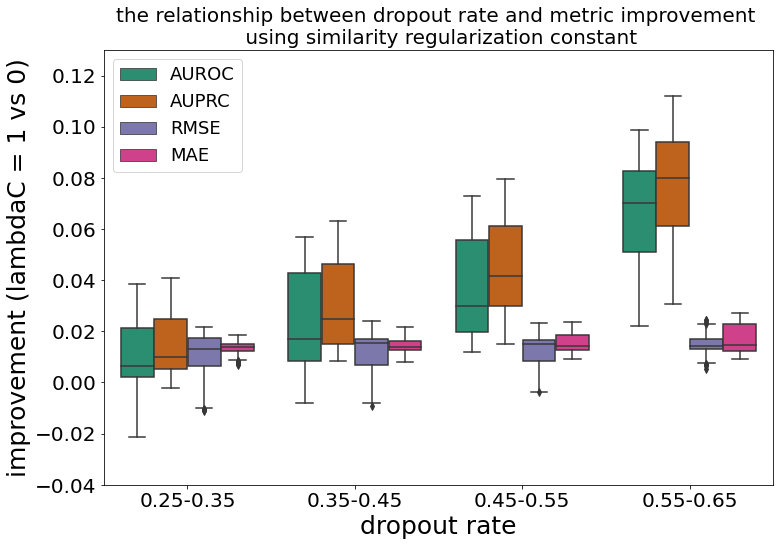

In [35]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='drop_rate', y='improvement', data=df_box, hue='label', palette='Dark2', ax=ax)

ax.set_xlabel('dropout rate', fontsize=25)
ax.set_ylabel('improvement (lambdaC = 1 vs 0)', fontsize=25)
ax.set_ylim(-0.04, 0.13)
ax.legend(fontsize=18)
plt.tick_params(labelsize=20)
plt.title("the relationship between dropout rate and metric improvement \n using similarity regularization constant", fontsize=20)
plt.savefig("basic_sim_droprate_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()


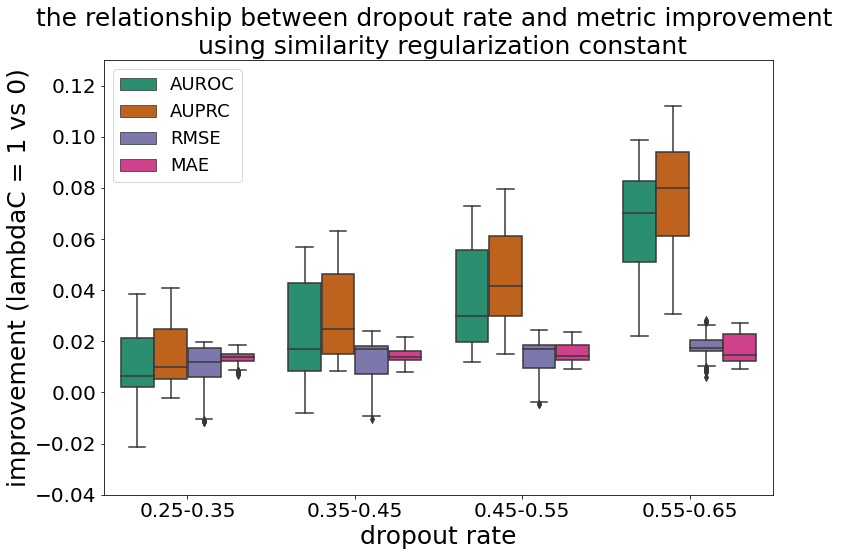

In [356]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='drop_rate', y='improvement', data=df_box, hue='label', palette='Dark2', ax=ax)

ax.set_xlabel('dropout rate', fontsize=25)
ax.set_ylabel('improvement (lambdaC = 1 vs 0)', fontsize=25)
ax.set_ylim(-0.04, 0.13)
ax.legend(fontsize=18)
plt.tick_params(labelsize=20)
plt.title("the relationship between dropout rate and metric improvement \n using similarity regularization constant", fontsize=25)
plt.savefig("basic_sim_droprate_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()


scOpenと比較もする

## 類似度制約の強さによる改善度合い
S_lsi_Mでの0,0.1,1で比較、それなりにある
S_lsi_Xでの0,0.1,1で比較、ない

In [36]:
results = pd.read_csv("simulation1_20210131_results_m{}_ncl{}_nincl{}_sparse{}_hetero{}.tsv".format(m, n_cl, n_incl, sparse_rate, hetero_rate), sep="\t", index_col=0)
results["RMSE"] = np.sqrt(results["RMSE"])
results_fix = results
results_fix.loc[results_fix["sim_matrix"] == "X","lambdaC"] = "raw matrix"
# results_fix.loc[results_fix["sim_matrix"] == "scOpen","lambdaC"] = "scOpen"
results_fix

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,v1,100,8,10,0.3,0.2,0.472693,X,0,1,1,raw matrix,0.609524,0.142625,0.763376,0.834689
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0,0.545056,0.159271,0.934994,0.897490
2,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0,0.545056,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.543840,0.156675,0.939060,0.902168
4,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.1,0.544124,0.156706,0.938201,0.901501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,v5,100,8,10,0.3,0.2,0.416030,scOpen,10,1,1,0,0.490847,0.127599,0.975590,0.950150
2996,v5,100,8,10,0.3,0.2,0.416030,scOpen,20,1,1,0,0.511630,0.137600,0.957531,0.930582
2997,v5,100,8,10,0.3,0.2,0.416030,scOpen,30,1,1,0,0.520799,0.141174,0.948000,0.920324
2998,v5,100,8,10,0.3,0.2,0.416030,scOpen,40,1,1,0,0.528543,0.143754,0.942836,0.912083


In [37]:
results_fix#[["lambdaC", "RMSE"]]

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,v1,100,8,10,0.3,0.2,0.472693,X,0,1,1,raw matrix,0.609524,0.142625,0.763376,0.834689
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0,0.545056,0.159271,0.934994,0.897490
2,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0,0.545056,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.543840,0.156675,0.939060,0.902168
4,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.1,0.544124,0.156706,0.938201,0.901501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,v5,100,8,10,0.3,0.2,0.416030,scOpen,10,1,1,0,0.490847,0.127599,0.975590,0.950150
2996,v5,100,8,10,0.3,0.2,0.416030,scOpen,20,1,1,0,0.511630,0.137600,0.957531,0.930582
2997,v5,100,8,10,0.3,0.2,0.416030,scOpen,30,1,1,0,0.520799,0.141174,0.948000,0.920324
2998,v5,100,8,10,0.3,0.2,0.416030,scOpen,40,1,1,0,0.528543,0.143754,0.942836,0.912083


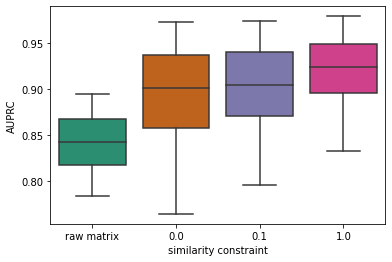

In [38]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='lambdaC', y='AUPRC', data=results_fix, palette='Dark2', ax=ax)

ax.set_xlabel('similarity constraint')
ax.set_ylabel('AUPRC')
# ax.set_ylim(-0.03, 0.1)
# ax.legend()

# plt.savefig("basic_sim_droprate_improvement.png")
plt.show()


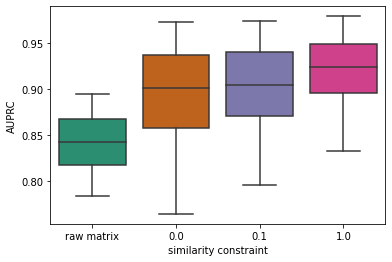

In [39]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='lambdaC', y='AUPRC', data=results_fix, palette='Dark2', ax=ax)

ax.set_xlabel('similarity constraint')
ax.set_ylabel('AUPRC')
# ax.set_ylim(-0.03, 0.1)
# ax.legend()

# plt.savefig("basic_sim_droprate_improvement.png")
plt.show()


In [40]:
results_fix

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,v1,100,8,10,0.3,0.2,0.472693,X,0,1,1,raw matrix,0.609524,0.142625,0.763376,0.834689
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0,0.545056,0.159271,0.934994,0.897490
2,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0,0.545056,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.543840,0.156675,0.939060,0.902168
4,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.1,0.544124,0.156706,0.938201,0.901501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,v5,100,8,10,0.3,0.2,0.416030,scOpen,10,1,1,0,0.490847,0.127599,0.975590,0.950150
2996,v5,100,8,10,0.3,0.2,0.416030,scOpen,20,1,1,0,0.511630,0.137600,0.957531,0.930582
2997,v5,100,8,10,0.3,0.2,0.416030,scOpen,30,1,1,0,0.520799,0.141174,0.948000,0.920324
2998,v5,100,8,10,0.3,0.2,0.416030,scOpen,40,1,1,0,0.528543,0.143754,0.942836,0.912083


In [41]:
fuga = pd.DataFrame({
    "value": [],
    "method": [],
    "label": []
})
for label in ["AUROC", "AUPRC", "RMSE", "MAE"]:
    df = results_fix.loc[:,[label, "lambdaC"]]
    df.columns = ["value", "method"]    
    df["label"] = label
    fuga = pd.concat([fuga, df])

fuga

,value,method,label
0,0.763376,raw matrix,AUROC
1,0.934994,0,AUROC
2,0.934994,0,AUROC
3,0.939060,0.1,AUROC
4,0.938201,0.1,AUROC
...,...,...,...
2995,0.127599,0,MAE
2996,0.137600,0,MAE
2997,0.141174,0,MAE
2998,0.143754,0,MAE


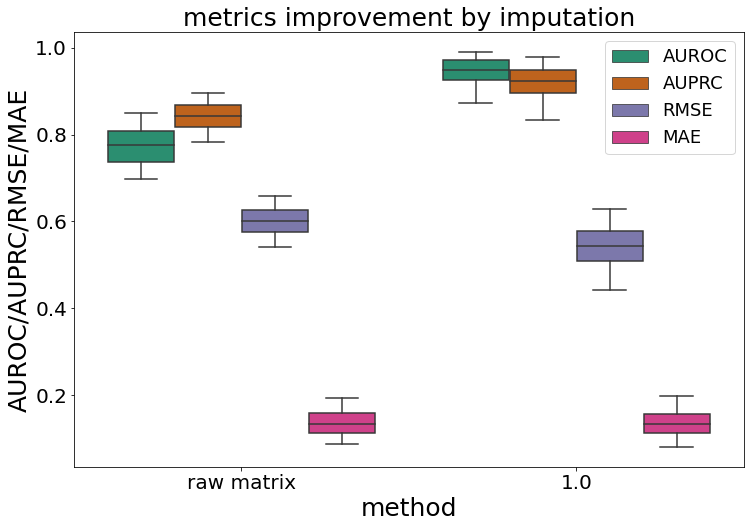

In [42]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='method', y='value', data=fuga[fuga["method"].isin(["raw matrix",1])], hue='label', palette='Dark2', ax=ax)

ax.set_xlabel('method', fontsize=25)
ax.set_ylabel('AUROC/AUPRC/RMSE/MAE', fontsize=25)
plt.tick_params(labelsize=20)
ax.legend(fontsize=18)
plt.title("metrics improvement by imputation", fontsize=25)
# plt.savefig("basic_sim_X_similarity_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()


In [52]:
results = pd.read_csv("simulation1_20210131_results_m{}_ncl{}_nincl{}_sparse{}_hetero{}.tsv".format(m, n_cl, n_incl, sparse_rate, hetero_rate), sep="\t", index_col=0)
results["RMSE"] = np.sqrt(results["RMSE"])
results = results[results["sim_matrix"] == "S_lsi_M"]
results

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.0,0.545056,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.543840,0.156675,0.939060,0.902168
5,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,1.0,0.537352,0.148323,0.954636,0.919801
7,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,8,1,1,0.0,0.528643,0.139184,0.964675,0.934240
9,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,8,1,1,0.1,0.525136,0.134341,0.970315,0.941083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,40,1,1,0.1,0.556291,0.132933,0.925558,0.898675
2985,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,40,1,1,1.0,0.543955,0.124092,0.959861,0.937131
2987,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,50,1,1,0.0,0.563467,0.133723,0.919577,0.889785
2989,v5,100,8,10,0.3,0.2,0.416030,S_lsi_M,50,1,1,0.1,0.559933,0.130114,0.938287,0.910457


In [53]:
hoge1 = pd.DataFrame({
    "RMSE": [],
    "MAE": [],
    "AUROC": [],
    "AUPRC": []
})
hoge2 = pd.DataFrame({
    "RMSE": [],
    "MAE": [],
    "AUROC": [],
    "AUPRC": []
})


for r in rs:
    print(r)
    df_hoge = results[results["r"]== r]
    df_diff1 = df_hoge[df_hoge["lambdaC"] == 0.1][["RMSE", "MAE", "AUROC", "AUPRC"]].to_numpy() - df_hoge[df_hoge["lambdaC"] == 0][["RMSE", "MAE", "AUROC", "AUPRC"]].to_numpy()
    df_diff2 = df_hoge[df_hoge["lambdaC"] == 1][["RMSE", "MAE", "AUROC", "AUPRC"]].to_numpy() - df_hoge[df_hoge["lambdaC"] == 0][["RMSE", "MAE", "AUROC", "AUPRC"]].to_numpy()
 
    print(df_diff1.shape)
    print(df_diff2.shape)
    
    hoge1 = pd.concat([hoge1, pd.DataFrame(df_diff1, columns=hoge1.columns)])
    hoge2 = pd.concat([hoge2, pd.DataFrame(df_diff2, columns=hoge2.columns)])

#     rmses.append(df_diff["RMSE"])
#     maes.append(df_diff["MAE"])
#     rocs.append(df_diff["AUROC"])
#     prs.append(df_diff["AUPRC"])


5
(60, 4)
(60, 4)
8
(60, 4)
(60, 4)
10
(60, 4)
(60, 4)
20
(60, 4)
(60, 4)
30
(60, 4)
(60, 4)
40
(60, 4)
(60, 4)
50
(60, 4)
(60, 4)


In [54]:
hoge1["similarity"] = "0 vs 0.1"
hoge2["similarity"] = "0 vs 1"
hoge1["RMSE"] = hoge1["RMSE"] * -1
hoge2["RMSE"] = hoge2["RMSE"] * -1
hoge1["MAE"] = hoge1["MAE"] * -1
hoge2["MAE"] = hoge2["MAE"] * -1

In [55]:
hoge3 = pd.DataFrame({
    "RMSE": [],
    "MAE": [],
    "AUROC": [],
    "AUPRC": []
})

results = pd.read_csv("simulation1_20210131_results_m{}_ncl{}_nincl{}_sparse{}_hetero{}.tsv".format(m, n_cl, n_incl, sparse_rate, hetero_rate), sep="\t", index_col=0)
results = results[results["sim_matrix"].isin(["S_lsi_X", "scOpen"])]
df_diff3 = results[results["lambdaC"]==1][["RMSE", "MAE", "AUROC", "AUPRC"]].to_numpy() - results[results["sim_matrix"]=="scOpen"][["RMSE", "MAE", "AUROC", "AUPRC"]].to_numpy()
hoge3 = pd.concat([hoge3, pd.DataFrame(df_diff3, columns=hoge3.columns)])
hoge3["similarity"] = "scOpen vs 1"
hoge3["RMSE"] = hoge3["RMSE"] * -1
hoge3["MAE"] = hoge3["MAE"] * -1

In [56]:
hoge = pd.concat([hoge1, hoge2, hoge3])
hoge

,RMSE,MAE,AUROC,AUPRC,similarity
0,0.001215,0.002596,0.004066,0.004678,0 vs 0.1
1,0.001618,0.002783,0.005571,0.006801,0 vs 0.1
2,0.001354,0.002714,0.004111,0.005037,0 vs 0.1
3,0.001410,0.002930,0.007363,0.009038,0 vs 0.1
4,0.002125,0.003144,0.009614,0.010537,0 vs 0.1
...,...,...,...,...,...
415,-0.014728,0.007168,-0.000685,-0.000004,scOpen vs 1
416,-0.017190,0.009836,-0.004084,-0.001579,scOpen vs 1
417,-0.021530,0.011631,-0.003979,-0.000978,scOpen vs 1
418,-0.021197,0.015134,0.003374,0.007871,scOpen vs 1


In [57]:
hogehoge = pd.DataFrame({
    "improvement": [],
    "similarity": [],
    "label": []
})
for label in ["AUROC", "AUPRC", "RMSE", "MAE"]:
    df = hoge.loc[:,[label, "similarity"]]
    df.columns = ["improvement", "similarity"]    
    df["label"] = label
    hogehoge = pd.concat([hogehoge, df])

In [58]:
hogehoge

,improvement,similarity,label
0,0.004066,0 vs 0.1,AUROC
1,0.005571,0 vs 0.1,AUROC
2,0.004111,0 vs 0.1,AUROC
3,0.007363,0 vs 0.1,AUROC
4,0.009614,0 vs 0.1,AUROC
...,...,...,...
415,0.007168,scOpen vs 1,MAE
416,0.009836,scOpen vs 1,MAE
417,0.011631,scOpen vs 1,MAE
418,0.015134,scOpen vs 1,MAE


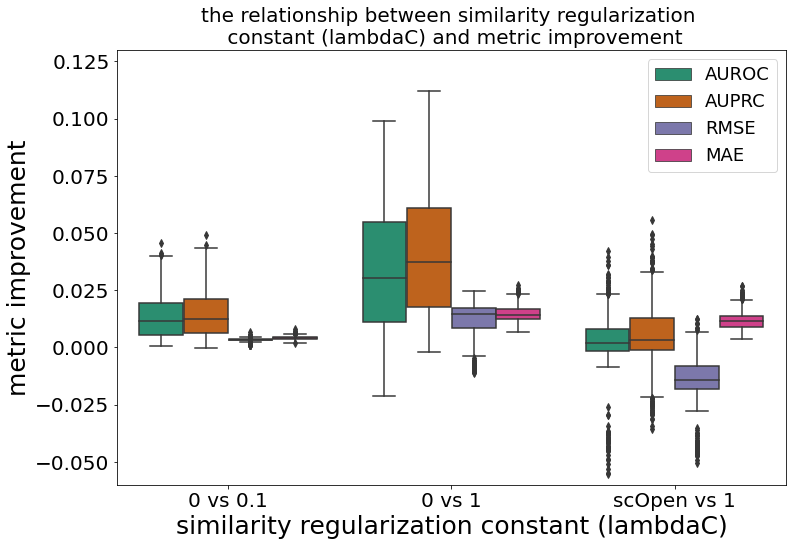

In [59]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='similarity', y='improvement', data=hogehoge, hue='label', palette='Dark2', ax=ax)

ax.set_xlabel('similarity regularization constant (lambdaC)', fontsize=25)
ax.set_ylabel('metric improvement', fontsize=25)
ax.set_ylim(-0.06, 0.13)
plt.tick_params(labelsize=20)
ax.legend(fontsize=18)
plt.title("the relationship between similarity regularization \n constant (lambdaC) and metric improvement", fontsize=20)
plt.savefig("basic_sim_X_similarity_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()


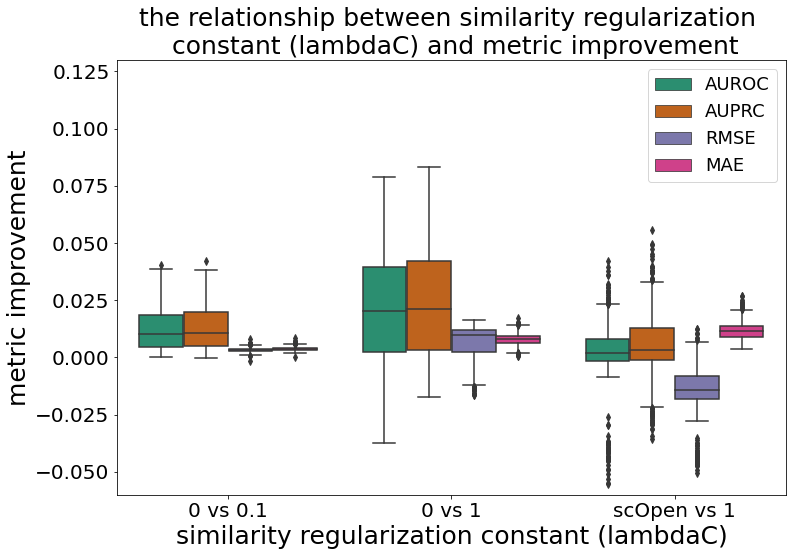

In [783]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(x='similarity', y='improvement', data=hogehoge, hue='label', palette='Dark2', ax=ax)

ax.set_xlabel('similarity regularization constant (lambdaC)', fontsize=25)
ax.set_ylabel('metric improvement', fontsize=25)
ax.set_ylim(-0.06, 0.13)
plt.tick_params(labelsize=20)
ax.legend(fontsize=18)
plt.title("the relationship between similarity regularization \n constant (lambdaC) and metric improvement", fontsize=25)
plt.savefig("basic_sim_X_similarity_improvement_m{}_ncl{}_nincl{}_sparse{}_hetero{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate))
plt.show()


## ROC, PR曲線の可視化

In [386]:
results = pd.read_csv("simulation1_20210131_results_m{}_ncl{}_nincl{}_sparse{}_hetero{}.tsv".format(m, n_cl, n_incl, sparse_rate, hetero_rate), sep="\t", index_col=0)
results

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,v1,100,8,10,0.3,0.2,0.472693,X,0,1,1,0.0,0.371520,0.142625,0.763376,0.834689
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.0,0.297086,0.159271,0.934994,0.897490
2,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.0,0.297086,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.295762,0.156675,0.939060,0.902168
4,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.1,0.296071,0.156706,0.938201,0.901501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,v5,100,8,10,0.3,0.2,0.416030,scOpen,10,1,1,0.0,0.240931,0.127599,0.975590,0.950150
2996,v5,100,8,10,0.3,0.2,0.416030,scOpen,20,1,1,0.0,0.261765,0.137600,0.957531,0.930582
2997,v5,100,8,10,0.3,0.2,0.416030,scOpen,30,1,1,0.0,0.271232,0.141174,0.948000,0.920324
2998,v5,100,8,10,0.3,0.2,0.416030,scOpen,40,1,1,0.0,0.279357,0.143754,0.942836,0.912083


In [385]:
results = results[(results["drop_rate"] > 0.45) & (results["drop_rate"] < 0.55)]
results

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
0,v1,100,8,10,0.3,0.2,0.472693,X,0,1,1,0.0,0.371520,0.142625,0.763376,0.834689
1,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.0,0.297086,0.159271,0.934994,0.897490
2,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.0,0.297086,0.159271,0.934994,0.897490
3,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,0.1,0.295762,0.156675,0.939060,0.902168
4,v1,100,8,10,0.3,0.2,0.472693,S_lsi_X,5,1,1,0.1,0.296071,0.156706,0.938201,0.901501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,v5,100,8,10,0.3,0.2,0.489172,scOpen,10,1,1,0.0,0.272865,0.148515,0.960639,0.926192
2546,v5,100,8,10,0.3,0.2,0.489172,scOpen,20,1,1,0.0,0.296310,0.159184,0.931460,0.894656
2547,v5,100,8,10,0.3,0.2,0.489172,scOpen,30,1,1,0.0,0.307450,0.163224,0.914910,0.876598
2548,v5,100,8,10,0.3,0.2,0.489172,scOpen,40,1,1,0.0,0.311862,0.162840,0.912428,0.874572


In [387]:
results = results[(results["drop_rate"] > 0.45) & (results["drop_rate"] < 0.55)]
results_WHS= results[(results["sim_matrix"].isin(["S_lsi_M"])) & (results["lambdaC"] == 1)]
results_SO = results[results["sim_matrix"] == "scOpen"]

In [388]:
results_SO

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
43,v1,100,8,10,0.3,0.2,0.472693,scOpen,5,1,1,0.0,0.292263,0.165860,0.936379,0.896009
44,v1,100,8,10,0.3,0.2,0.472693,scOpen,8,1,1,0.0,0.262484,0.138237,0.974388,0.944768
45,v1,100,8,10,0.3,0.2,0.472693,scOpen,10,1,1,0.0,0.269117,0.141758,0.969172,0.938746
46,v1,100,8,10,0.3,0.2,0.472693,scOpen,20,1,1,0.0,0.291718,0.153886,0.941902,0.908928
47,v1,100,8,10,0.3,0.2,0.472693,scOpen,30,1,1,0.0,0.299989,0.156551,0.934363,0.901114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,v5,100,8,10,0.3,0.2,0.489172,scOpen,10,1,1,0.0,0.272865,0.148515,0.960639,0.926192
2546,v5,100,8,10,0.3,0.2,0.489172,scOpen,20,1,1,0.0,0.296310,0.159184,0.931460,0.894656
2547,v5,100,8,10,0.3,0.2,0.489172,scOpen,30,1,1,0.0,0.307450,0.163224,0.914910,0.876598
2548,v5,100,8,10,0.3,0.2,0.489172,scOpen,40,1,1,0.0,0.311862,0.162840,0.912428,0.874572


In [389]:
results_WHS

,version,m,n_cl,n_incl,sparse_rate,hetero_rate,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC
5,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,5,1,1,1.0,0.288747,0.148323,0.954636,0.919801
11,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,8,1,1,1.0,0.264483,0.120346,0.979704,0.954674
17,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,10,1,1,1.0,0.265214,0.122194,0.979412,0.957250
23,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,20,1,1,1.0,0.296164,0.136965,0.954104,0.929348
29,v1,100,8,10,0.3,0.2,0.472693,S_lsi_M,30,1,1,1.0,0.312357,0.140585,0.944627,0.918663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2517,v5,100,8,10,0.3,0.2,0.489172,S_lsi_M,10,1,1,1.0,0.276248,0.127448,0.976296,0.948947
2523,v5,100,8,10,0.3,0.2,0.489172,S_lsi_M,20,1,1,1.0,0.305535,0.141767,0.948958,0.919108
2529,v5,100,8,10,0.3,0.2,0.489172,S_lsi_M,30,1,1,1.0,0.320520,0.145121,0.938063,0.908061
2535,v5,100,8,10,0.3,0.2,0.489172,S_lsi_M,40,1,1,1.0,0.329409,0.145470,0.939852,0.908910


In [418]:
diff = pd.DataFrame(results_WHS[["AUROC", "AUPRC"]].to_numpy() - results_SO[["AUROC", "AUPRC"]].to_numpy())
diff.sort_values(0, ascending=False).head(20)

,0,1
62,0.036228,0.045288
75,0.034765,0.046604
89,0.032246,0.043153
96,0.032096,0.042045
33,0.029425,0.032533
54,0.029002,0.040516
12,0.028706,0.040298
61,0.028009,0.036692
95,0.027799,0.036928
68,0.027519,0.035276


In [419]:
pd.DataFrame(results_WHS.iloc[36,:])

,711
version,v2
m,100
n_cl,8
n_incl,10
sparse_rate,0.3
hetero_rate,0.2
drop_rate,0.478602
sim_matrix,S_lsi_M
r,8
lambdaW,1


In [420]:
pd.DataFrame(results_SO.iloc[36,:])

,744
version,v2
m,100
n_cl,8
n_incl,10
sparse_rate,0.3
hetero_rate,0.2
drop_rate,0.478602
sim_matrix,scOpen
r,8
lambdaW,1


In [760]:
X = M.copy()
drop_rates = []
for j in range(M.shape[1]):
    n_drop = np.random.poisson(math.floor(M[:,j].sum() / 2), 1) + 1
#     print(n_drop)
    n_drop = n_drop[0]
    if n_drop >= M[:,j].sum():
        n_drop = int(M[:,j].sum() - 1)
#     print(n_drop,  M[:,j].sum(), n_drop / M[:,j].sum())
    drop_rates.append(n_drop / M[:,j].sum())
    drop_idxs = np.random.choice(np.where(M[:,j] == 1)[0], n_drop, replace=False)
    for drop_idx in drop_idxs:
        X[drop_idx,j] = 0

drop_rate = np.array(drop_rates).mean()
print(drop_rate)
##
M_bin = M.copy()

0.4983183678475703


In [761]:
r = 5
lambdaC = 1

In [762]:
WH, W, H, errors = CMF_Impute(X, S_lsi_M, r, 1,1,0, False)

In [763]:
WH_S, W_S, H_S, errors_S = CMF_Impute(X, S_lsi_M, r, 1,1,lambdaC, False)

In [764]:
pd.DataFrame(X).to_csv("hoge.tsv", sep="\t")

!scopen --input hoge.tsv --input-format dense --output-dir ./ --output-prefix hoge_scOpen --output-format dense --n-components {r}          
SO = pd.read_csv("hoge_scOpen.txt", sep="\t", index_col=0).to_numpy()

SO[SO < 0] = 0

AA_SO = X.astype(float)
for i in range(X.shape[0]):
#         if i % 100 == 0:
#             print(i)
    for j in range(X.shape[1]):
        if X[i,j] == 0:
            AA_SO[i,j] = SO[i,j]

WH[WH < 0] = 0
WH_S[WH_S < 0] = 0

AA = X.astype(float)
for i in range(X.shape[0]):
    if i % 100 == 0:
        print(i)
    for j in range(X.shape[1]):
        if X[i,j] == 0:
            AA[i,j] = WH[i,j]
            
AA_S = X.astype(float)
for i in range(X.shape[0]):
    if i % 100 == 0:
        print(i)
    for j in range(X.shape[1]):
        if X[i,j] == 0:
            AA_S[i,j] = WH_S[i,j]

Number of peaks: 100; number of cells 80
Sparsity before imputation: 0.848625
Sparsity after imputation: 0.13949999999999996
[total time:  0h 0m 0s ]
0
0


In [765]:
rmse_aa = mean_squared_error(M_bin, AA, squared=False)
mae_aa = mean_absolute_error(M_bin, AA)
print(rmse_aa, mae_aa)

rmse_aa_S = mean_squared_error(M_bin, AA_S, squared=False)
mae_aa_S = mean_absolute_error(M_bin, AA_S)
print(rmse_aa_S, mae_aa_S)

rmse_so = mean_squared_error(M_bin, AA_SO, squared=False)
mae_so = mean_absolute_error(M_bin, AA_SO)
print(rmse_so, mae_so)

0.31437535732425137 0.17065119787701716
0.3075393522947213 0.16107268720760168
0.305193335427395 0.17658014522875


In [766]:
fpr_nhmf_aa, tpr_nhmf_aa, thresholds_nhmf_aa = roc_curve(M_bin.flatten(), AA.flatten())
roc_auc_nhmf_aa = auc(fpr_nhmf_aa, tpr_nhmf_aa)
print(roc_auc_nhmf_aa)

fpr_nhmf_aa_S, tpr_nhmf_aa_S, thresholds_nhmf_S = roc_curve(M_bin.flatten(), AA_S.flatten())
roc_auc_nhmf_aa_S = auc(fpr_nhmf_aa_S, tpr_nhmf_aa_S)
print(roc_auc_nhmf_aa_S)

fpr_so, tpr_so, thresholds_so = roc_curve(M_bin.flatten(), AA_SO.flatten())
roc_auc_so = auc(fpr_so, tpr_so)
print(roc_auc_so)

precision_nhmf_aa, recall_nhmf_aa, thresholds_pr_nhmf_aa = precision_recall_curve(M_bin.flatten(), AA.flatten())
auprc_nhmf_aa= auc(recall_nhmf_aa, precision_nhmf_aa)
print(auprc_nhmf_aa)

precision_nhmf_aa_S, recall_nhmf_aa_S, thresholds_pr_nhmf_aa_S = precision_recall_curve(M_bin.flatten(), AA_S.flatten())
auprc_nhmf_aa_S= auc(recall_nhmf_aa_S, precision_nhmf_aa_S)
print(auprc_nhmf_aa_S)

precision_so, recall_so, thresholds_pr_so = precision_recall_curve(M_bin.flatten(), AA_SO.flatten())
auprc_so= auc(recall_so, precision_so)
print(auprc_nhmf_so)

0.9193590738154871
0.9368845446284106
0.9219665905682262
0.8756792520456901
0.8992066140416678
0.8888345415520055


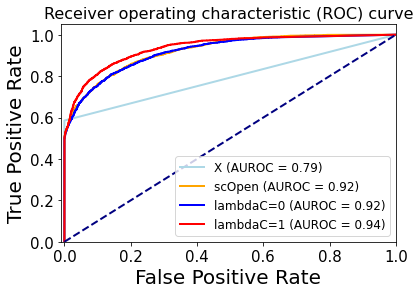

In [784]:
lw = 2
plt.plot(fpr_x, tpr_x, color='lightblue', lw=lw, label='X (AUROC = %0.2f)' % roc_auc_x)
plt.plot(fpr_so, tpr_so, color='orange', lw=lw, label='scOpen (AUROC = %0.2f)' % roc_auc_so)
plt.plot(fpr_nhmf_aa, tpr_nhmf_aa, color='blue', lw=lw, label='lambdaC=0 (AUROC = %0.2f)' % roc_auc_nhmf_aa)
plt.plot(fpr_nhmf_aa_S, tpr_nhmf_aa_S, color='red', lw=lw, label='lambdaC=1 (AUROC = %0.2f)' % roc_auc_nhmf_aa_S)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver operating characteristic (ROC) curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.tick_params(labelsize=15)
plt.savefig("basic_sim_roc_m{}_ncl{}_nincl{}_sparse{}_hetero{}_r{}_drop{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate, r, drop_rate))
plt.show()


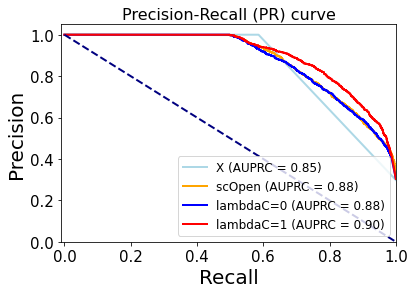

In [770]:
lw = 2
plt.plot(recall_x, precision_x, color='lightblue', lw=lw, label='X (AUPRC = %0.2f)' % auprc_x)
plt.plot(recall_so, precision_so, color='orange', lw=lw, label='scOpen (AUPRC = %0.2f)' % auprc_so)
plt.plot(recall_nhmf_aa, precision_nhmf_aa, color='blue', lw=lw, label='lambdaC=0 (AUPRC = %0.2f)' % auprc_nhmf_aa)
plt.plot(recall_nhmf_aa_S, precision_nhmf_aa_S, color='red', lw=lw, label='lambdaC=1 (AUPRC = %0.2f)' % auprc_nhmf_aa_S)


plt.plot([0, 1], [1, 0], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.title('Precision-Recall (PR) curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.tick_params(labelsize=15)
plt.savefig("basic_sim_pr_m{}_ncl{}_nincl{}_sparse{}_hetero{}_r{}_drop{}.png".format(m, n_cl, n_incl, sparse_rate, hetero_rate, r, drop_rate))
plt.show()


In [297]:
# pd.DataFrame(WH).to_csv("/home/naoto/scOpen/basic_sim/{}/easiestWH.tsv".format(version), sep="\t", index=False,header=None)
# pd.DataFrame(WH_S).to_csv("/home/naoto/scOpen/basic_sim/{}/easiestWH_S.tsv".format(version), sep="\t", index=False,header=None)
pd.DataFrame(AA).to_csv("/home/naoto/scOpen/basic_sim/{}/easiestAA.tsv".format(version), sep="\t", index=False,header=None)
pd.DataFrame(AA_S).to_csv("/home/naoto/scOpen/basic_sim/{}/easiestAA_S.tsv".format(version), sep="\t", index=False,header=None)
pd.DataFrame(X).to_csv("/home/naoto/scOpen/basic_sim/{}/easiestX.tsv".format(version), sep="\t", index=False,header=None)

In [298]:
# WH_lsi = pd.read_csv("/home/naoto/scOpen/basic_sim/{}/easiestWH_lsi.tsv".format(version), sep="\t")
# WH_S_lsi = pd.read_csv("/home/naoto/scOpen/basic_sim/{}/easiestWH_S_lsi.tsv".format(version), sep="\t")
AA_lsi = pd.read_csv("/home/naoto/scOpen/basic_sim/{}/easiestAA_lsi.tsv".format(version), sep="\t")
AA_S_lsi = pd.read_csv("/home/naoto/scOpen/basic_sim/{}/easiestAA_S_lsi.tsv".format(version), sep="\t")
X_lsi = pd.read_csv("/home/naoto/scOpen/basic_sim/{}/easiestX_lsi.tsv".format(version), sep="\t")


In [258]:
n_dim = 10

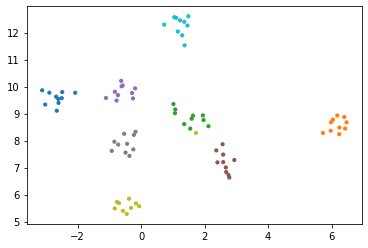

In [259]:
embedding_AA = umap.UMAP().fit_transform(AA_lsi.iloc[:,1:10])
plt.scatter(embedding_AA[:,0],embedding_AA[:,1],c=label,cmap=cm.tab10, s=10)

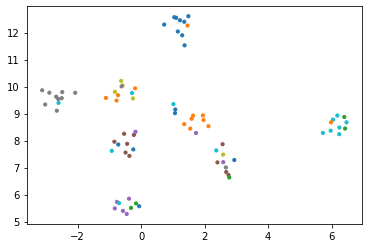

In [260]:
plt.scatter(embedding_AA[:,0],embedding_AA[:,1],c=AA_label_k,cmap=cm.tab10, s=10)

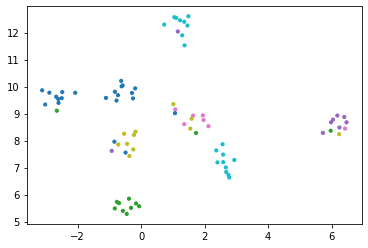

In [261]:
plt.scatter(embedding_AA[:,0],embedding_AA[:,1],c=AA_label_l,cmap=cm.tab10, s=10)

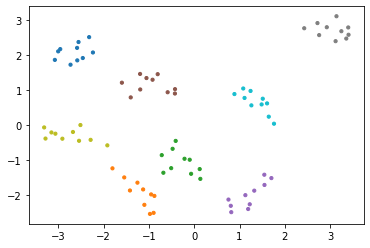

In [306]:
embedding_AA_S = umap.UMAP().fit_transform(AA_S_lsi.iloc[:,1:n_dim])
plt.scatter(embedding_AA_S[:,0],embedding_AA_S[:,1],c=label,cmap=cm.tab10, s=10)

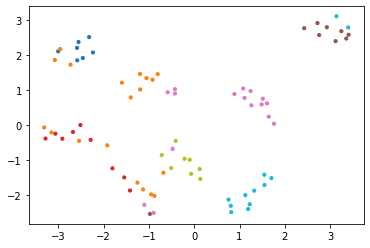

In [310]:
plt.scatter(embedding_AA_S[:,0],embedding_AA_S[:,1],c=AA_S_label_l,cmap=cm.tab10, s=10)

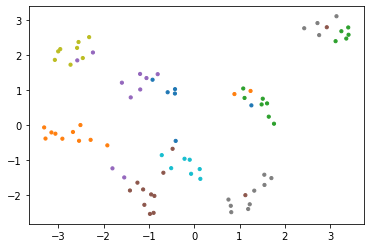

In [308]:
plt.scatter(embedding_AA_S[:,0],embedding_AA_S[:,1],c=AA_S_label_k,cmap=cm.tab10, s=10)

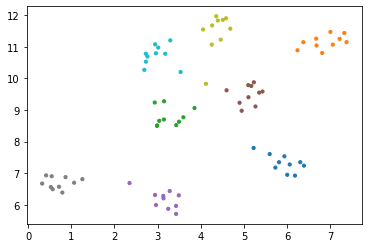

In [265]:
embedding_X = umap.UMAP().fit_transform(X_lsi.iloc[:,1:n_dim])
plt.scatter(embedding_X[:,0],embedding_X[:,1],c=label,cmap=cm.tab10, s=10)

In [300]:
n_components = 20
n_cluster = n
n_nns = n_incl

kmeans = KMeans(n_clusters=n_cluster, random_state=10).fit(X_lsi.iloc[:, 1:n_components])
X_label_k = kmeans.labels_
kmeans = KMeans(n_clusters=n_cluster, random_state=10).fit(AA_lsi.iloc[:, 1:n_components])
AA_label_k = kmeans.labels_
kmeans = KMeans(n_clusters=n_cluster, random_state=10).fit(AA_S_lsi.iloc[:, 1:n_components])
AA_S_label_k = kmeans.labels_

kARI_AAimputed = ARI(label_cat, AA_label_k)
kARI_AA_Simputed = ARI(label_cat, AA_S_label_k)
kARI_raw = ARI(label_cat, X_label_k)

kNMI_AAimputed = NMI(label_cat, AA_label_k)
kNMI_AA_Simputed = NMI(label_cat, AA_S_label_k)
kNMI_raw = NMI(label_cat, X_label_k)

# Louvain clustering
A = kneighbors_graph(X_lsi.iloc[:, 1:n_components], n_nns)
G = nx.convert_matrix.from_numpy_array(A.toarray())
AA_label_l = list(community.best_partition(G).values())

A = kneighbors_graph(AA_lsi.iloc[:, 1:n_components], n_nns)
G = nx.convert_matrix.from_numpy_array(A.toarray())
AA_S_label_l = list(community.best_partition(G).values())

A = kneighbors_graph(AA_S_lsi.iloc[:, 1:n_components], n_nns)
G = nx.convert_matrix.from_numpy_array(A.toarray())
X_label_l = list(community.best_partition(G).values())


lARI_AAimputed = ARI(label_cat, AA_label_l)
lARI_AA_Simputed = ARI(label_cat, AA_S_label_l)
lARI_raw = ARI(label_cat, X_label_l)

lNMI_AAimputed = NMI(label_cat, AA_label_l)
lNMI_AA_Simputed = NMI(label_cat, AA_S_label_l)
lNMI_raw = NMI(label_cat, X_label_l)

In [301]:
print(kARI_AA_Simputed, kARI_AAimputed, kARI_raw)
print(kNMI_AA_Simputed, kNMI_AAimputed, kNMI_raw)
print(lARI_AA_Simputed, lARI_AAimputed, lARI_raw)
print(lNMI_AA_Simputed, lNMI_AAimputed, lNMI_raw)


0.5359653346172365 0.3212603426071309 0.48001810535050826
0.7166011623612805 0.573258410965768 0.6622389466198284
0.47057189485746037 0.6184312210200927 0.6120898443979961
0.6782022037439375 0.7889204511647301 0.7641741082321963


In [148]:
# # pca向き
n_components = 15
n_cluster = n_cl
n_nns = n_incl
pca = PCA(n_components=n_components)
pca_X = pca.fit(X)
# pca_WH = pca.fit(WH)
pca_WH = pca.fit(AA)
pca_WH_S = pca.fit(AA_S)
print(pca_X.components_.T.shape)

# PCAじゃなくてLSIでやりたいところ

# initialization dependency

for _i in range(10):

    # kmeans = KMeans(n_clusters=n_cluster).fit(pca_X.components_.T)
    kmeans = KMedoids(n_clusters=n_cluster, init="k-medoids++").fit(pca_X.components_.T)
    X_label_k = kmeans.labels_
    # kmeans = KMeans(n_clusters=n_cluster).fit(pca_WH.components_.T)
    kmeans = KMedoids(n_clusters=n_cluster, init="k-medoids++").fit(pca_WH.components_.T)
    WH_label_k = kmeans.labels_
    # kmeans = KMeans(n_clusters=n_cluster).fit(pca_WH_S.components_.T)
    kmeans = KMedoids(n_clusters=n_cluster, init="k-medoids++").fit(pca_WH_S.components_.T)
    WH_S_label_k = kmeans.labels_

    kARI_WHimputed = ARI(label_cat, WH_label_k)
    kARI_WH_Simputed = ARI(label_cat, WH_S_label_k)
    kARI_raw = ARI(label_cat, X_label_k)

    kNMI_WHimputed = NMI(label_cat, WH_label_k)
    kNMI_WH_Simputed = NMI(label_cat, WH_S_label_k)
    kNMI_raw = NMI(label_cat, X_label_k)

    # Louvain clustering
    A = kneighbors_graph(pca_WH.components_.T, n_nns)
    G = nx.convert_matrix.from_numpy_array(A.toarray())
    WH_label_l = list(community.best_partition(G).values())

    A = kneighbors_graph(pca_WH_S.components_.T, n_nns)
    G = nx.convert_matrix.from_numpy_array(A.toarray())
    WH_S_label_l = list(community.best_partition(G).values())

    A = kneighbors_graph(pca_X.components_.T, n_nns)
    G = nx.convert_matrix.from_numpy_array(A.toarray())
    X_label_l = list(community.best_partition(G).values())


    lARI_WHimputed = ARI(label_cat, WH_label_l)
    lARI_WH_Simputed = ARI(label_cat, WH_S_label_l)
    lARI_raw = ARI(label_cat, X_label_l)

    lNMI_WHimputed = NMI(label_cat, WH_label_l)
    lNMI_WH_Simputed = NMI(label_cat, WH_S_label_l)
    lNMI_raw = NMI(label_cat, X_label_l)

(80, 15)


In [106]:
WH_label_k

array([1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 3, 3, 4, 3, 3, 2, 3, 3, 2, 1, 0, 0,
       2, 5, 1, 6, 6, 6, 5, 7, 7, 4, 7, 7, 7, 7, 0, 0, 7, 0, 2, 2, 2, 7,
       2, 2, 2, 6, 2, 2, 4, 1, 7, 4, 2, 0, 0, 4, 4, 4, 2, 6, 6, 5, 2, 6,
       5, 5, 2, 6, 1, 3, 2, 1, 4, 0, 2, 5, 2, 3], dtype=int32)

In [107]:
label_cat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [108]:
X_label_k

array([3, 2, 5, 2, 1, 2, 0, 3, 2, 2, 7, 5, 5, 1, 5, 6, 5, 5, 5, 7, 4, 4,
       4, 4, 0, 0, 1, 4, 4, 4, 7, 7, 3, 3, 1, 7, 7, 3, 7, 3, 6, 6, 6, 5,
       6, 6, 1, 6, 6, 2, 1, 0, 1, 0, 1, 0, 1, 0, 0, 7, 0, 0, 0, 0, 6, 5,
       0, 7, 7, 3, 0, 3, 3, 0, 1, 1, 1, 2, 0, 2], dtype=int32)

In [149]:
print(kARI_WH_Simputed, kARI_WHimputed, kARI_raw)
print(kNMI_WH_Simputed, kNMI_WHimputed, kNMI_raw)
print(lARI_WH_Simputed, lARI_WHimputed, lARI_raw)
print(lNMI_WH_Simputed, lNMI_WHimputed, lNMI_raw)


0.5320517479467985 0.5526714133542635 0.4757340126022255
0.7057645907163804 0.7050998844239263 0.6939367557686408
0.9111921901193176 0.7973050808999355 0.9111921901193176
0.940443372758238 0.9130938059930692 0.940443372758238


In [200]:
# 保存

In [311]:
record =  pd.Series([version, m, n, n_incl, drop_rate, "X", r, 1, 1, 0, rmse_x, mae_x, roc_auc_x, auprc_x, kARI_raw, kNMI_raw, lARI_raw, lNMI_raw], index=results.columns)
results = results.append(record, ignore_index=True)

In [286]:
record =  pd.Series([version, m, n, n_incl, drop_rate, "S_lsi_M", r, 1, 1, 0, rmse_aa, mae_aa, roc_auc_nhmf_aa, auprc_nhmf_aa, kARI_AAimputed, kNMI_AAimputed, lARI_AAimputed, lNMI_AAimputed], index=results.columns)
results = results.append(record, ignore_index=True)

In [302]:
record =  pd.Series([version, m, n, n_incl, drop_rate, "S_lsi_M", r, 1, 1, lambdaC, rmse_aa_S, mae_aa_S, roc_auc_nhmf_aa_S, auprc_nhmf_aa_S, kARI_AA_Simputed, kNMI_AA_Simputed, lARI_AA_Simputed, lNMI_AA_Simputed], index=results.columns)
results = results.append(record, ignore_index=True)

In [312]:
results

,version,m,n,n_incl,drop_rate,sim_matrix,r,lambdaW,lambdaH,lambdaC,RMSE,MAE,AUROC,AUPRC,kARI,kNMI,lARI,lNMI
0,v1,100,8,10,0.589248,X,30,1,1,0,0.439898,0.195625,0.705827,0.803640,0.517758,0.691538,1.000000,1.000000
1,v1,100,8,10,0.589248,S_lsi_M,30,1,1,0,0.390449,0.194835,0.872724,0.848827,0.353369,0.533707,0.499906,0.686397
2,v1,100,8,10,0.589248,S_lsi_M,30,1,1,1,0.371758,0.177609,0.940696,0.928995,0.894939,0.938696,0.405637,0.561164
3,v1,100,8,10,0.508215,X,30,1,1,0,0.408321,0.169000,0.745865,0.830365,0.480018,0.662239,0.797243,0.887737
4,v1,100,8,10,0.508215,S_lsi_M,30,1,1,0,0.352230,0.167796,0.905296,0.891674,0.570359,0.727890,0.670970,0.803119
5,v1,100,8,10,0.508215,S_lsi_M,30,1,1,1,0.332552,0.150420,0.963301,0.956080,1.000000,1.000000,0.340791,0.527242
6,v1,100,8,10,0.508215,S_lsi_M,8,1,1,0,0.276391,0.133306,0.988118,0.984592,0.321260,0.573258,0.643267,0.782300
7,v1,100,8,10,0.508215,S_lsi_M,8,1,1,1,0.262260,0.112437,0.998789,0.998475,0.709723,0.813606,0.267327,0.481599
8,v1,100,8,10,0.508215,S_lsi_M,8,1,1,0.1,0.273154,0.128297,0.992098,0.989764,0.535965,0.716601,0.470572,0.678202
9,v1,100,8,10,0.508215,X,8,1,1,0,0.408321,0.169000,0.745865,0.830365,0.480018,0.662239,0.612090,0.764174


/usr/local/package/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


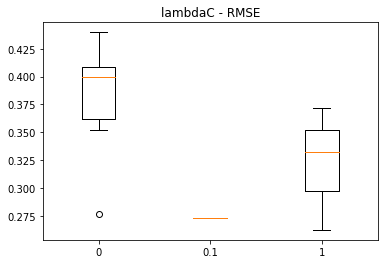

In [313]:
zero = results[results["lambdaC"]==0]["RMSE"]
zeroone = results[results["lambdaC"]==0.1]["RMSE"]
one = results[results["lambdaC"]==1]["RMSE"]
data = (zero, zeroone, one)
fig1, ax1 = plt.subplots()
ax1.set_title('lambdaC - RMSE')
ax1.set_xticklabels(['0', '0.1', '1'])
ax1.boxplot(data)
plt.show()

/usr/local/package/python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


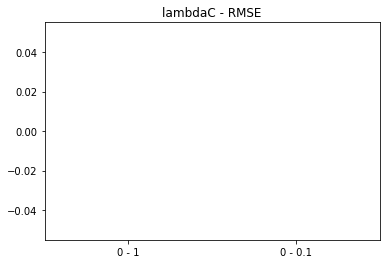

In [314]:
zero_one = results[results["lambdaC"]==0]["RMSE"] - results[results["lambdaC"]==1]["RMSE"]
zero_zeroone = results[results["lambdaC"]==0]["RMSE"] - results[results["lambdaC"]==0.1]["RMSE"]
data = (zero_one, zero_zeroone)
fig1, ax1 = plt.subplots()
ax1.set_title('lambdaC - RMSE')
ax1.set_xticklabels(['0 - 1', '0 - 0.1'])
ax1.boxplot(data)
plt.show()

In [316]:
results[results["lambdaC"]==0]["RMSE"]

0    0.439898
1    0.390449
3    0.408321
4    0.352230
6    0.276391
9    0.408321
Name: RMSE, dtype: float64

In [317]:
results[results["lambdaC"]==1]["RMSE"]

2    0.371758
5    0.332552
7    0.262260
Name: RMSE, dtype: float64

In [ ]:
zero = results[results["lambdaC"]==0]["RMSE"]
zeroone = results[results["lambdaC"]==0.1]["RMSE"]
one = results[results["lambdaC"]==1]["RMSE"]
data = (zero, zeroone, one)
fig1, ax1 = plt.subplots()
ax1.set_title('lambdaC - RMSE')
ax1.set_xticklabels(['0', '0.1', '1'])
ax1.boxplot(data)
plt.show()